# Carlini Wagner Attacks

In [ ]:
# IF YOU ARE IN COLAB OR HAVE NOT INSTALLED `xlab-security`
!pip install xlab-security # should not take more than a minute or two to run

In [1]:
import xlab
xlab.hello_world()

# get CIFAR10 helper functions 
from xlab.utils import CIFAR10
itos, stoi = CIFAR10.itos, CIFAR10.stoi

# for loading our model
from robustbench.utils import load_model

# pytorch imports
import torch
from torch import nn
from torch.nn import functional as F
from torch import optim

# for plotting
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print(f"You are using device: {device}")

Hello world! You are using version 0.1.8 of the package
You are using device: mps


In [2]:
# load our data
NUM_EXAMPLES = 100
x_test, y_test = xlab.utils.load_cifar10_test_samples(n=NUM_EXAMPLES)
x_test, y_test = x_test.to(device), y_test.to(device)
print(f"{x_test.shape=}, {y_test.shape=}")

x_test.shape=torch.Size([100, 3, 32, 32]), y_test.shape=torch.Size([100])


We will begin by loading a pretrained model for classification on CIFAR using robustbench. This is a much larger more impressive model than the one you looked at in the previous section.

In [3]:
from huggingface_hub import hf_hub_download
from xlab.models import MiniWideResNet, BasicBlock

# https://huggingface.co/uchicago-xlab-ai-security/tiny-wideresnet-cifar10
model_path = hf_hub_download(
    repo_id="uchicago-xlab-ai-security/tiny-wideresnet-cifar10",
    filename="adversarial_basics_cnn.pth"
)
model = torch.load(model_path, map_location=device, weights_only=False)
_ = model.eval()

This is the same model that you were using in the previous notebook. As a refresher, you can see that the model has 165,722 trainable paramters, but image classifiers can get much larger.

In [4]:
# print the parameter count
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable_params:,}")

Trainable parameters: 165,722


## Tasks 1-5: Writing the function $f(x + \delta)$

Recall that we will be using a loss to minimize the equation below.
$$
\ell = \mathcal{D}(x, x + \delta) + c \cdot f (x + \delta)
$$

The function $\mathcal{D}$ measures how different $x$ (the original image) is from $x + \delta$ where $\delta$ is the purtubations we are making to the image. In the original paper, Carlini and Wagner list seven of reasonable choices you could make for $f$. For brevity, you will only implement and compare 3 of them. 

Note that the equations below are presented slightly differently than in the original paper. They are all mathematically equivalent, but we have rewritten some for clarity. 

<details>
<summary>⚠️ <b>Caution</b></summary>

In this section we will have you implement 3 out of the 7 choices for $f$. We encourage you to implement the other choices of $f$ from [the paper](https://arxiv.org/pdf/1608.04644) if you are interested. We will caution you however that there appears to be a sign error in equation #1. The correct equation with the right signs should be shown below. Cross Entropy here will be taken with $\log_2$ rather than $\log_e$.

$$
f_1(x_{\mathrm{adversarial}}) = \mathrm{CrossEntropy}(F(x_{\mathrm{adversarial}})) - 1
$$

In general we find that the "Objective Function" section of the paper has several mistakes . For example they say that they "define an objective function $f$ such that $C(x + \delta) = t$ if and only if $f(x + \delta) \leq 0$." but it is trivial to show that equation 4 does not satisfy the "if and only if" condition.

</details>

### Task #1: Implementing $f_2$

For task #1 you will implement $f_2$ from [the paper](https://arxiv.org/pdf/1608.04644). 

The equation for $f_2$ is below. $F_t(x)$ is the model output for class $t$ including the [softmax](https://docs.pytorch.org/docs/stable/generated/torch.nn.Softmax.html) which gives probabilities rather than logits. The first term in this equation takes the greatest softmax probability that is not the target class. We encourage you to pause and think about why the equation is structured in the way that it is.

$$
f_2(x_{\mathrm{adversarial}}) = \mathrm{ReLU}(\max_{i \neq t}(F(x_{\mathrm{adversarial}})) - F_t(x_{\mathrm{adversarial}}))
$$

In [5]:
def f2(logits, target):
    softmax_probs = F.softmax(logits, dim=0)
    i_neq_t = torch.argmax(softmax_probs)
    if i_neq_t == target:
        masked_probs = softmax_probs.clone()
        masked_probs[target] = float('-inf')
        i_neq_t = torch.argmax(masked_probs)
    return F.relu(softmax_probs[i_neq_t] - softmax_probs[target])

In [6]:
x = torch.tensor([1.0, 3.0])
print(f2(x, 0)) # should be >0
x = torch.tensor([1.0, 1.0])
print(f2(x, 0)) # should be =0
x = torch.tensor([3.0, 1.0])
print(f2(x, 0)) # should be =0

tensor(0.7616)
tensor(0.)
tensor(0.)


In [7]:
_ = xlab.tests.cw.task1(f2)

============================= test session starts ==============================
collected 30 items / 26 deselected / 4 selected

PASSED [ 25%]ts/cw.py::test_f2_output_shape_and_type 
PASSED   [ 50%]/cw.py::test_f2_target_not_max 
PASSED    [ 75%]cw.py::test_f2_target_is_max 
PASSED [100%]ts/cw.py::test_f2_large_confidence_gap 

======================= 4 passed, 26 deselected in 0.02s =======================
✅ All checks passed!


### Task #2: Implementing $f_4$

This is similar to the equation above. The only difference is that we are inforcing the requirement that the target class has a probability greater than or equal to 0.5 rather a probability greater than or equal to any of the other classes.

$$
f_4(x_{\mathrm{adversarial}}) = \mathrm{ReLU}(0.5 - F_t(x_{\mathrm{adversarial}}))
$$

In [8]:
def f4(logits, target):
    softmax_probs = F.softmax(logits, dim=0)
    return F.relu(0.5 - softmax_probs[target])

In [9]:
x = torch.tensor([1.0, 3.0])
print(f4(x, 0)) # should be >0
x = torch.tensor([1.0, 1.0])
print(f4(x, 0)) # should be =0
x = torch.tensor([3.0, 1.0])
print(f4(x, 0)) # should be =0

tensor(0.3808)
tensor(0.)
tensor(0.)


In [10]:
_ = xlab.tests.cw.task2(f4)

============================= test session starts ==============================
collected 30 items / 26 deselected / 4 selected

PASSED [ 25%]ts/cw.py::test_f4_output_shape_and_type 
PASSED [ 50%]ts/cw.py::test_f4_target_prob_above_threshold 
PASSED [ 75%]ts/cw.py::test_f4_target_prob_below_threshold 
PASSED [100%]ts/cw.py::test_f4_target_prob_near_threshold 

======================= 4 passed, 26 deselected in 0.01s =======================
✅ All checks passed!


### Task #3: Implementing $f_6$

This is very similar ot $f_2$. The difference is we use $Z_t(x)$ instead of $F_t(x)$. $Z_t(x)$ is the raw output of the model for class $t$ rather than the output after the softmax.

$$
f_6(x_{\mathrm{adversarial}}) = \mathrm{ReLU}(\max_{i \neq t}(Z(x_{\mathrm{adversarial}})) - Z_t(x_{\mathrm{adversarial}}))
$$

In [11]:
def f6(logits, target):
    # softmax_probs = F.softmax(logits, dim=0)
    i_neq_t = torch.argmax(logits)
    if i_neq_t == target:
        masked_logits = logits.clone()
        masked_logits[target] = float('-inf')
        i_neq_t = torch.argmax(masked_logits)
    return F.relu(logits[i_neq_t] - logits[target])

In [12]:
x = torch.tensor([1.0, 3.0])
print(f6(x, 0)) # should be >0
x = torch.tensor([1.0, 1.0])
print(f6(x, 0)) # should be =0
x = torch.tensor([3.0, 1.0])
print(f6(x, 0)) # should be =0

tensor(2.)
tensor(0.)
tensor(0.)


By now you should have several options for $f$. Now we can optimize the below equation below where we let $\mathcal{D}(x, x + \delta)$ be the $L_2$ norm.

$$
\ell = \mathcal{D}(x, x + \delta) + c \cdot f (x + \delta)
$$


We have implemented this below for you. The attack is extremely similar to the PGD attack you coded in the previous notebook so it should look familiar to you. Still, you should read through the code and make sure you understand everything!

In [13]:
def cw_loss_v1(f, x, y, delta, c, model):
    logits = model(x + delta)
    f_loss = f(logits[0], y)
    norm_loss = (torch.sum(delta**2))**1/2

    return norm_loss + c * f_loss

def cw_simple(f, x, y, c, model, num_iters):
    delta = torch.randn_like(x) * 0.1
    delta.requires_grad = True
    optimizer = optim.Adam([delta], lr=1e-2)

    for i in range(num_iters):
        l = cw_loss_v1(f, x, y, delta, c, model)
        l.backward()
        optimizer.step()
        optimizer.zero_grad()
        if (i + 1) % 5 == 0:
            print(f"iteration {i + 1}:\t loss={l.item():.4f}")
    return torch.clip(x + delta, 0, 1)

### Task #4: Test different $f$ functions

The next step is to fill in the missing code below to test how effective different choices of $f$ are. When running `benchmark_f` for `f2`, `f4` and `f6` you should find that one choice of $f$ is much more effective than the other two.

<details>
<summary>💡 <b>Hint </b></summary>

$f_6$ Should have 100% attack success rate for the 5 images we selected. When we run our code we get:

* f2_results = [6, 1, 1, 1, 6]
* f4_results = [3, 1, 1, 0, 6]
* f6_results = [1, 1, 1, 1, 1]

</details>

In [14]:
def benchmark_f(f, num_imgs=5, num_iters=40, target_class=1, c=1):
    print(f"running attacks on {num_imgs} images with target='{itos[target_class]}'")

    results = []
    for i in range(num_imgs):
        x_clean = x_test[i:i+1].to(device) # tensor is [1, 3, 32, 32]
        
        adv_image = cw_simple(f, x_clean, target_class, c, model, num_iters) ### YOUR CODE HERE ###
        predicted_class = torch.argmax(model(adv_image)).item() ### YOUR CODE HERE ###
        print(f"model predicts class 'target='{itos[predicted_class]}'")
        results.append(predicted_class)

    return results

In [15]:
f2_results = benchmark_f(f2)

running attacks on 5 images with target='automobile'
iteration 5:	 loss=10.5963
iteration 10:	 loss=5.1606
iteration 15:	 loss=2.6532
iteration 20:	 loss=1.3993
iteration 25:	 loss=1.3214
iteration 30:	 loss=0.5777
iteration 35:	 loss=0.6016
iteration 40:	 loss=0.4792
model predicts class 'target='automobile'
iteration 5:	 loss=9.2751
iteration 10:	 loss=4.3775
iteration 15:	 loss=1.8231
iteration 20:	 loss=1.1477
iteration 25:	 loss=0.7082
iteration 30:	 loss=0.4560
iteration 35:	 loss=0.7407
iteration 40:	 loss=0.8586
model predicts class 'target='automobile'
iteration 5:	 loss=9.7418
iteration 10:	 loss=4.9393
iteration 15:	 loss=2.7244
iteration 20:	 loss=1.6925
iteration 25:	 loss=0.9600
iteration 30:	 loss=0.8436
iteration 35:	 loss=0.6247
iteration 40:	 loss=0.5421
model predicts class 'target='ship'
iteration 5:	 loss=9.5995
iteration 10:	 loss=4.5093
iteration 15:	 loss=2.4976
iteration 20:	 loss=1.7830
iteration 25:	 loss=1.3344
iteration 30:	 loss=0.9345
iteration 35:	 loss=

In [16]:
f4_results = benchmark_f(f4)

running attacks on 5 images with target='automobile'
iteration 5:	 loss=8.3363
iteration 10:	 loss=3.6051
iteration 15:	 loss=1.8213
iteration 20:	 loss=1.1840
iteration 25:	 loss=0.9130
iteration 30:	 loss=0.7629
iteration 35:	 loss=0.6706
iteration 40:	 loss=0.6094
model predicts class 'target='cat'
iteration 5:	 loss=8.2942
iteration 10:	 loss=3.2765
iteration 15:	 loss=1.5630
iteration 20:	 loss=0.8015
iteration 25:	 loss=0.5935
iteration 30:	 loss=0.6008
iteration 35:	 loss=0.4278
iteration 40:	 loss=0.2327
model predicts class 'target='ship'
iteration 5:	 loss=8.5434
iteration 10:	 loss=3.6987
iteration 15:	 loss=1.8019
iteration 20:	 loss=0.7076
iteration 25:	 loss=0.5037
iteration 30:	 loss=0.6958
iteration 35:	 loss=0.5988
iteration 40:	 loss=0.3485
model predicts class 'target='automobile'
iteration 5:	 loss=8.0714
iteration 10:	 loss=3.5246
iteration 15:	 loss=1.4870
iteration 20:	 loss=0.9456
iteration 25:	 loss=0.6702
iteration 30:	 loss=0.5599
iteration 35:	 loss=0.3687
i

In [17]:
f6_results = benchmark_f(f6)

running attacks on 5 images with target='automobile'
iteration 5:	 loss=13.8763
iteration 10:	 loss=10.7277
iteration 15:	 loss=7.5985
iteration 20:	 loss=5.1014
iteration 25:	 loss=3.3264
iteration 30:	 loss=2.1401
iteration 35:	 loss=1.3695
iteration 40:	 loss=1.0189
model predicts class 'target='automobile'
iteration 5:	 loss=12.0100
iteration 10:	 loss=7.5947
iteration 15:	 loss=4.4624
iteration 20:	 loss=2.5486
iteration 25:	 loss=1.7126
iteration 30:	 loss=1.7846
iteration 35:	 loss=1.7741
iteration 40:	 loss=1.5349
model predicts class 'target='automobile'
iteration 5:	 loss=13.5155
iteration 10:	 loss=10.0259
iteration 15:	 loss=6.7713
iteration 20:	 loss=4.3104
iteration 25:	 loss=2.9352
iteration 30:	 loss=2.3149
iteration 35:	 loss=1.8296
iteration 40:	 loss=1.3690
model predicts class 'target='automobile'
iteration 5:	 loss=13.6870
iteration 10:	 loss=10.0242
iteration 15:	 loss=6.7755
iteration 20:	 loss=4.4059
iteration 25:	 loss=2.8341
iteration 30:	 loss=1.8270
iteratio

In [18]:
_ = xlab.tests.cw.task4(f2_results, f4_results, f6_results, 1)

============================= test session starts ==============================
collected 30 items / 28 deselected / 2 selected

PASSED [ 50%]ts/cw.py::test_arrays_have_equal_length 
PASSED [100%]ts/cw.py::test_third_array_has_most_occurrences 

======================= 2 passed, 28 deselected in 0.01s =======================
✅ All checks passed!


## Task #5: choosing a value for $c$

In the previous section you should have seen that the we picked a hardcoded value for $c$. But is there a better strategy than guessing? In the paper, the authors say:

<blockquote>
    Empirically, we have found that often the best way to choose $c$ is to use the smallest value of $c$ for which the resulting solution $x^{*}$ has $f(x^{*}) \leq 0$. This causes gradient descent to minimize both of the terms simultaneously instead of picking only one to optimize over first.
</blockquote>

In other words, to find the ideal result, we want our optimizer to make improvements that minimize the $f$ function but also have the minimum possible impact on the $L_p$ norm. If the $c$ value is too larger, the $f$ function will dominate the loss and the optimizer may allow for a larger $L_p$ norm than is strictly necessary. If $c$ is too small, the attack won't be successful. By choosing the smallest possible $c$ that makes the attack successful, we get the best of both worlds.

In the code below you will benchmark different $c$ values for a small subset of CIFAR 10.

<details>
<summary>💡 <b>Hint for Task #5</b></summary>

A good starting point is to make sure that you are using the correct arguments to call `cw_simple`. From there, you should run your example back through the model to see if the attack was successful. In our code, we have:

```python
adv_image = cw_simple(f, x_clean, target_class, c, model, cw_iters)
predicted_class = torch.argmax(model(adv_image)).item()
```

</details>


<details>
<summary>🔐 <b>Solution for Task #5</b></summary>

```python
def bechmark_c_values(num_images, cw_iters, f, target_class):
    c_values = [1e-3, 1e-2, 1e-1, 1e1, 1e2, 1e3]
    c_values_to_prob = {c: 0 for c in c_values}
    c_values_to_l2_sum = {c: 0 for c in c_values}

    for c in c_values:
        ######### OPTIONAL: INIT VARIABLES HERE #########

        completed_attacks = 0
        img_idx = 0
        while completed_attacks < num_images:
            print(f"c = {c}: \tattack #{completed_attacks+1}")
            x_clean = x_test[img_idx:img_idx+1].to(device)
            img_idx += 1

            # we should not try to attack an image if the target label = the clean label
            if target_class == y_test[img_idx:img_idx+1].item():
                continue

            ######### YOUR CODE STARTS HERE #########
            # 1. find adversarial image using cw_simple, with arguments cw_iters & f   
            adv_image = cw_simple(f, x_clean, target_class, c, model, cw_iters)
            
            # 2. check if cw attack was successful & update c_values_to_prob
            predicted_class = torch.argmax(model(adv_image)).item()
            if predicted_class == target_class:
                c_values_to_prob[c] += 1
            
            # 3. calculate l2 norm (use distance func) & update c_values_to_l2_sum
            c_values_to_l2_sum[c] += distance(adv_image, x_clean, 2).item()
            ######### YOUR CODE ENDS HERE #########
            
            completed_attacks += 1

    ######### OPTIONAL: FINAL PROCESSING HERE #########
    for c,l2_sum in c_values_to_l2_sum.items():
        c_values_to_l2_sum[c] = l2_sum/num_images
    for c,succ_count in c_values_to_prob.items():
        c_values_to_prob[c] = succ_count/num_images
    return c_values_to_l2_sum, c_values_to_prob
```
</details>

In [19]:
def distance(x1, x2, p):
    return torch.sum(torch.abs(x1 -x2)**p) ** (1/p)

In [20]:
def bechmark_c_values(num_images, cw_iters, f, target_class):
    c_values = [1e-3, 1e-2, 1e-1, 1e1, 1e2, 1e3]
    c_values_to_prob = {c: 0 for c in c_values}
    c_values_to_l2_sum = {c: 0 for c in c_values}

    for c in c_values:
        ######### OPTIONAL: INIT VARIABLES HERE #########

        completed_attacks = 0
        img_idx = 0
        while completed_attacks < num_images:
            print(f"c = {c}: \tattack #{completed_attacks+1}")
            x_clean = x_test[img_idx:img_idx+1].to(device)
            img_idx += 1

            # we should not try to attack an image if the target label = the clean label
            if target_class == y_test[img_idx:img_idx+1].item():
                continue

            ######### YOUR CODE STARTS HERE #########
            # 1. find adversarial image using cw_simple, with arguments cw_iters & f   
            adv_image = cw_simple(f, x_clean, target_class, c, model, cw_iters)
            
            # 2. check if cw attack was successful & update c_values_to_prob
            predicted_class = torch.argmax(model(adv_image)).item()
            if predicted_class == target_class:
                c_values_to_prob[c] += 1
            
            # 3. calculate l2 norm (use distance func) & update c_values_to_l2_sum
            c_values_to_l2_sum[c] += distance(adv_image, x_clean, 2).item()
            ######### YOUR CODE ENDS HERE #########
            
            completed_attacks += 1

    ######### OPTIONAL: FINAL PROCESSING HERE #########
    for c,l2_sum in c_values_to_l2_sum.items():
        c_values_to_l2_sum[c] = l2_sum/num_images
    for c,succ_count in c_values_to_prob.items():
        c_values_to_prob[c] = succ_count/num_images
    return c_values_to_l2_sum, c_values_to_prob

In [21]:
c_values_to_l2_sum, c_values_to_prob =bechmark_c_values(5, 15, f6, 1)

c = 0.001: 	attack #1
iteration 5:	 loss=7.6793
iteration 10:	 loss=3.1063
iteration 15:	 loss=1.3623
c = 0.001: 	attack #2
iteration 5:	 loss=7.8019
iteration 10:	 loss=3.1498
iteration 15:	 loss=1.3203
c = 0.001: 	attack #3
iteration 5:	 loss=7.9881
iteration 10:	 loss=3.2672
iteration 15:	 loss=1.4140
c = 0.001: 	attack #4
iteration 5:	 loss=8.1564
iteration 10:	 loss=3.3864
iteration 15:	 loss=1.4595
c = 0.001: 	attack #5
iteration 5:	 loss=7.6989
iteration 10:	 loss=3.0946
iteration 15:	 loss=1.3341
c = 0.01: 	attack #1
iteration 5:	 loss=8.1957
iteration 10:	 loss=3.3737
iteration 15:	 loss=1.4488
c = 0.01: 	attack #2
iteration 5:	 loss=8.0110
iteration 10:	 loss=3.2519
iteration 15:	 loss=1.3836
c = 0.01: 	attack #3
iteration 5:	 loss=7.8579
iteration 10:	 loss=3.2044
iteration 15:	 loss=1.3709
c = 0.01: 	attack #4
iteration 5:	 loss=7.7079
iteration 10:	 loss=3.0488
iteration 15:	 loss=1.2596
c = 0.01: 	attack #5
iteration 5:	 loss=8.1468
iteration 10:	 loss=3.3109
iteration 15

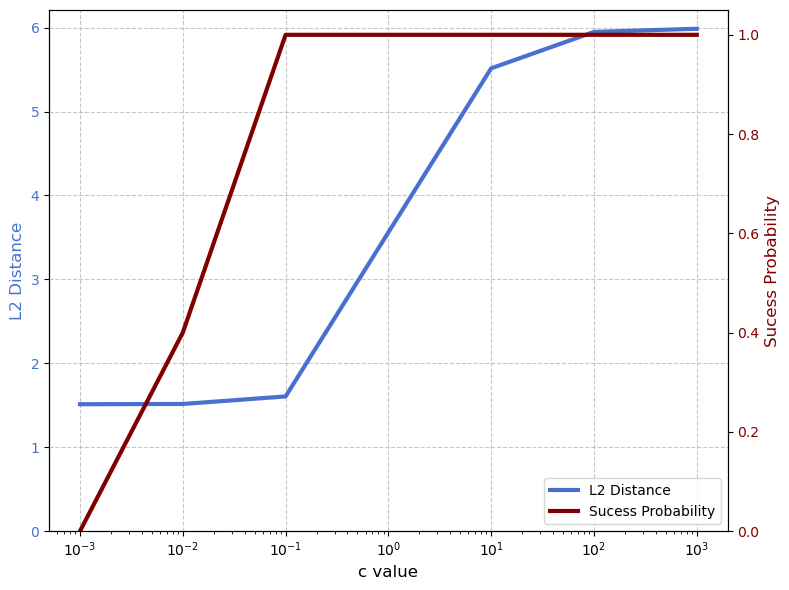

In [22]:
fig, ax1, ax2 = xlab.utils.plot_dual_2d(
    x=list(c_values_to_l2_sum.keys()), 
    y1=list(c_values_to_l2_sum.values()), 
    y2=list(c_values_to_prob.values()),
    y1_label='L2 Distance',
    y2_label='Sucess Probability',
    x_label='c value',
    y1_axis_label='L2 Distance',
    y2_axis_label='Sucess Probability',
    log_x=True,
)

### What do these results mean?

This shows that there is some tradeoff between $L_2$ distance and the probability of attack success. Perhaps an even better way to think about this is there is a tradeoff between how close an image is to it's original and how easily one can fool the model.

So if there is some kind of tradeoff present, how do we choose the best value for $c$? The author's make the following claim (note that $x^{*}$ is a notation for the adversarial example):

<blockquote>
    Empirically, we have found that often the best way to choose
$c$ is to use the smallest value of $c$ for which the resulting
solution $x^{*}$ has $f(x^{*}
)\leq 0$. This causes gradient descent to
minimize both of the terms simultaneously instead of picking
only one to optimize over first.
</blockquote>


In the paper the author's use a modified binary search to find this value of $c$. For brevity we leave this as an excercise to the reader but would not expect this to be too difficult to program. For our purposes, we observe that given a reasonable number of iterations in the $L_2$ setting, $c=0.015$ gives a high probability of success and undetectable perturbations in the $L_2$ setting.

## Task #6: Confidence-Adjusted $f$

For task 4 you found that $f_6$ was the most effective choice for $f$. For the $L_2$ attack that we will be implementing, the authors use a slight variation of $f_6$ which introduces a new constant $\tau$ which encourages the attack to find classifications that confidently choose the wrong class. This variation is shown below:

$$
f_6(x_{\mathrm{adversarial}}) = \max((\max_{i \neq t}(Z(x_{\mathrm{adversarial}}) - Z_t(x_{\mathrm{adversarial}})), -\tau)
$$

The $\tau$ parameter is different than the $c$ parameter because while the $c$ parameter weights how much the attack cares about the function $f$ the $\tau$ parameter determines a threshold for how confident of a misclassification $f$ is aiming for. 



In [23]:
def confident_f6(logits, target, tau):
    i_neq_t = torch.argmax(logits)
    if i_neq_t == target:
        masked_logits = logits.clone()
        masked_logits[target] = float('-inf')
        i_neq_t = torch.argmax(masked_logits)
    return torch.max((logits[i_neq_t] - logits[target]), -torch.tensor(tau))

In [24]:
tau = 0.01

x = torch.tensor([1.0, 3.0])
print(confident_f6(x, 0, tau)) # should be >0
x = torch.tensor([1.0, 1.0])
print(confident_f6(x, 0, tau)) # should be =0
x = torch.tensor([3.0, 1.0])
print(confident_f6(x, 0, tau)) # should be <0

tensor(2.)
tensor(0.)
tensor(-0.0100)


In [26]:
_ = xlab.tests.cw.task6(confident_f6)

============================= test session starts ==============================
collected 30 items / 24 deselected / 6 selected

PASSED [ 16%]ts/cw.py::test_confident_f6_output_shape_and_type 
PASSED [ 33%]ts/cw.py::test_confident_f6_target_not_max 
PASSED [ 50%]ts/cw.py::test_confident_f6_target_is_max 
PASSED [ 66%]ts/cw.py::test_confident_f6_tau_clamping 
PASSED [ 83%]ts/cw.py::test_confident_f6_no_clamping_needed 
PASSED [100%]ts/cw.py::test_confident_f6_different_tau_values 

======================= 6 passed, 24 deselected in 0.03s =======================
✅ All checks passed!


## Task 7-8: Change of variables

If you have not already read [our writeup for Carlini-Wagner attacks](https://xlabaisecurity.com/adversarial/cw/) on our website we highly recommend you do so now. Here is where things start to get tricky.

So far we have been thinking about adversarial examples as $x$ (the original image) plus a set of perturbations $\delta$ bounded by some $L_p$ norm. The issue is that $x + \delta$ can be greater than 1 or less than 0 which would make it an invalid image. Therefore, Carlini and Wagner propose writing $x + \delta$ as a function of a new variable $w$ where $f(w)$ is always between zero and one. Here is the equation they proposed:

$$
x_i + \delta_i = \frac{1}{2} (\tanh({w_i}) + 1)
$$

### Task #7: Caclculate $x + \delta$ given $w$

In task #6, you will calculate the above equation element-wise to find tensor $x + \delta$ given a tensor $w$.

In [27]:
def get_adv_from_w(w):
    return 0.5 * (torch.tanh(w) + 1)

In [28]:
_ = xlab.tests.cw.task7(get_adv_from_w)

============================= test session starts ==============================
collected 30 items / 26 deselected / 4 selected

PASSED [ 25%]ts/cw.py::test_get_adv_from_w_output_shape_and_type 
PASSED [ 50%]ts/cw.py::test_get_adv_from_w_value_range 
PASSED [ 75%]ts/cw.py::test_get_adv_from_w_specific_values 
PASSED [100%]ts/cw.py::test_get_adv_from_w_gradient_preservation 

======================= 4 passed, 26 deselected in 0.02s =======================
✅ All checks passed!


### Task #8: Caclculate $x + \delta$ given $w$

In task #7, you will find the tensor for $\delta$--i.e., the difference between $x$ and the adversarial image.

In [29]:
def get_delta(w, x):
    return 0.5 * (torch.tanh(w) + 1) - x

In [31]:
_ = xlab.tests.cw.task8(get_delta)

============================= test session starts ==============================
collected 30 items / 25 deselected / 5 selected

PASSED [ 20%]ts/cw.py::test_get_delta_output_shape_and_type 
PASSED [ 40%]ts/cw.py::test_get_delta_computation 
PASSED [ 60%]ts/cw.py::test_get_delta_zero_case 
PASSED [ 80%]ts/cw.py::test_get_delta_gradient_preservation 
PASSED [100%]ts/cw.py::test_get_delta_different_shapes 

======================= 5 passed, 25 deselected in 0.03s =======================
✅ All checks passed!


Now, let's plot what we have found. If we randomly initialize $w$ we should see large values for delta which are both positive and negative. However, $x+\delta$ should be between 0 and 1. <b>You should not expect to see a reasonable adversarial image if you randomly initialize $w$.</b>

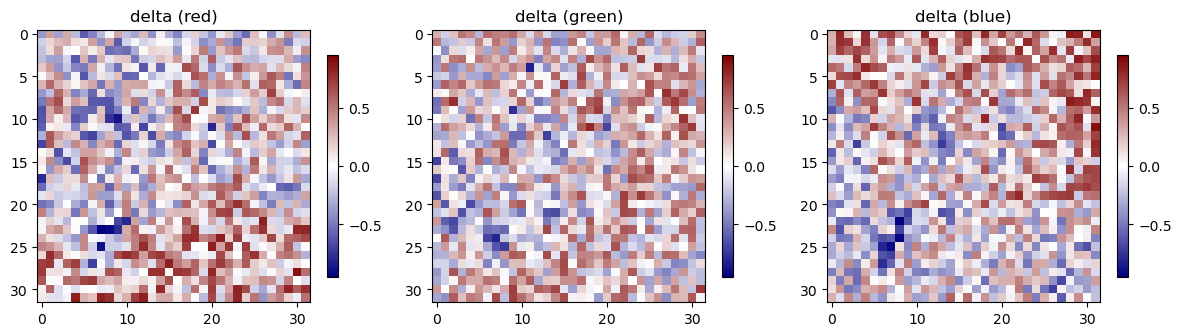

In [32]:
x_clean = x_test[0:0+1]
rand_w = torch.randn_like(x_clean)
adv = get_adv_from_w(rand_w)[0].cpu()
delta = get_delta(rand_w, x_clean)[0].cpu()

# you should expect to see positive and negative numbers
_ = xlab.utils.plot_tensors(
    [delta[0], delta[1], delta[2]],
    log_scale=False, 
    ncols=3,
    # log_scale=True,
    titles = ["delta (red)", "delta (green)", "delta (blue)"]
)

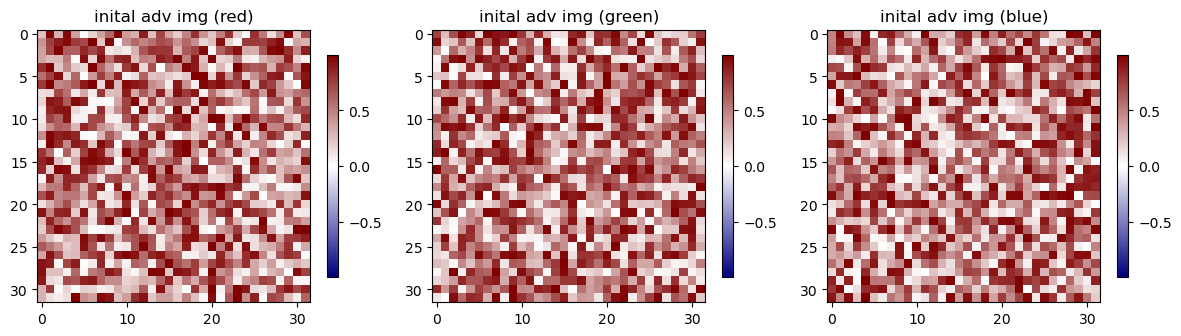

In [33]:
# you should expect to see plots of positive numbers between 0 and 1
_ = xlab.utils.plot_tensors(
    [adv[0], adv[1], adv[2]],
    log_scale=False, 
    ncols=3,
    # log_scale=True,
    titles = ["inital adv img (red)", "inital adv img (green)", "inital adv img (blue)"]
)

## Task #9: Putting it all together

Recall the following equation from [the webpage](https://xlabaisecurity.com/adversarial/cw/) associated with these exercises. This outlines the structure of the loss that the CW attack aims to minimize.

$$
\mathrm{minimize} \ \   \| \delta \|_p + c \cdot f(x + \delta)
$$

With the change of variable shown above, this becomes:

$$
\mathrm{minimize} \ \   \| \frac{1}{2} (\tanh({w}) + 1) - x \|_p + c \cdot f(\frac{1}{2} (\tanh({w}) + 1))
$$

Now we will use this equation to implement that $L_2$ Carlini-Wagner attack the way that the authors constructed it in the original paper. There are two details that require your attention before continuing: 

1. The authors use $\| \delta \|_2^2$ rather than $\| \delta \|_2$ to minimize the size of $\delta$.
2. The authors choose $f$ to be the function you implemented in `confident_f6` rather than the function you implemented in `f6`

This means your loss should look like this:

$$
\mathrm{minimize} \ \   \| \frac{1}{2} (\tanh({w}) + 1) - x \|_2^2 + c \cdot f_{\mathrm{6-confident}}(\frac{1}{2} (\tanh({w}) + 1))
$$

<details>
<summary>Hint for Task #9</summary>

The image for this function will be passes with a batch dimension because that is what the model expects. However, when you call `confident_f6` the logits for a single image are expected. Therefore, you should squeeze out the zeroth dimension, as shown below.

```python
success_loss = c * confident_f6(logits[0], target, k)
```
</details>

<details>
<summary>🔐 <b>Solution for Task #9</b></summary>

```python
def CW_targeted_l2(img, model, c, target, k=0.1, l2_limit=0.5, num_iters=50):
    device = next(model.parameters()).device
    print(f"Using device: {device} for testing...")

    # initalize cw weights and optimizer
    cw_weights = torch.randn_like(img).to(device) * 0.001
    cw_weights.requires_grad = True
    optimizer = optim.Adam([cw_weights], lr=5e-2)

    delta = get_delta(cw_weights, img)

    for _ in range(num_iters):
        # 1. Find logits
        logits = model(img + delta)

        # 2. Use c and confident_f6 to calculate the loss
        success_loss = c * confident_f6(logits[0], target, k)

        # 3. Find the L2 loss
        l2_reg = torch.sum((delta) ** 2)

        # 4. Call loss.backward(), optimizer.step(), optimizer.zero_grad()
        loss = success_loss + l2_reg
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        delta = get_delta(cw_weights, img)

    # print results of attack
    with torch.no_grad():
        print(f"total L2 loss:\t {torch.sum((delta) ** 2)}")
        
        logits = model(img + delta)
        if torch.argmax(logits[0]) == target:
            print(f"Attack was sucessful: classification={target}")
        else: 
            print(f"Attack was not sucessful: classification={torch.argmax(logits[0])}")
    
    return get_adv_from_w(cw_weights)

```
</details>


In [34]:
def CW_targeted_l2(img, model, c, target, k=0.1, l2_limit=0.5, num_iters=50):
    device = next(model.parameters()).device
    print(f"Using device: {device} for testing...")

    # initalize cw weights and optimizer
    cw_weights = torch.randn_like(img).to(device) * 0.001
    cw_weights.requires_grad = True
    optimizer = optim.Adam([cw_weights], lr=5e-2)

    delta = get_delta(cw_weights, img)

    for _ in range(num_iters):
        logits = model(img + delta)

        ######### YOUR CODE STARTS HERE ######### 
        # 1. Find logits
        # 2. Use c and confident_f6 to calculate the loss
        # 3. Find the L2 loss
        # 4. Call loss.backward(), optimizer.step(), optimizer.zero_grad()
        ######### YOUR CODE ENDS HERE #########

    # print results of attack
    with torch.no_grad():
        print(f"total L2 loss:\t {torch.sum((delta) ** 2)}")
        
        logits = model(img + delta)
        if torch.argmax(logits[0]) == target:
            print(f"Attack was sucessful: classification={target}")
        else: 
            print(f"Attack was not sucessful: classification={torch.argmax(logits[0])}")
    
    return get_adv_from_w(cw_weights)

In [35]:
def CW_targeted_l2(img, model, c, target, k=0.1, l2_limit=0.5, num_iters=50):
    device = next(model.parameters()).device
    print(f"Using device: {device} for testing...")

    # initalize cw weights and optimizer
    cw_weights = torch.randn_like(img).to(device) * 0.001
    cw_weights.requires_grad = True
    optimizer = optim.Adam([cw_weights], lr=5e-2)

    delta = get_delta(cw_weights, img)

    for _ in range(num_iters):
        # 1. Find logits
        logits = model(img + delta)

        # 2. Use c and confident_f6 to calculate the loss
        success_loss = c * confident_f6(logits[0], target, k)

        # 3. Find the L2 loss
        l2_reg = torch.sum((delta) ** 2)

        # 4. Call loss.backward(), optimizer.step(), optimizer.zero_grad()
        loss = success_loss + l2_reg
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        delta = get_delta(cw_weights, img)

    # print results of attack
    with torch.no_grad():
        print(f"total L2 loss:\t {torch.sum((delta) ** 2)}")
        
        logits = model(img + delta)
        if torch.argmax(logits[0]) == target:
            print(f"Attack was sucessful: classification={target}")
        else: 
            print(f"Attack was not sucessful: classification={torch.argmax(logits[0])}")
    
    return get_adv_from_w(cw_weights)


There are no automated tests for this final function but if you are able to misclassify the image of a cat using the code below, you solution is probably correct. We encourage you to also test on other images in the CIFAR-10 dataset.

In [38]:
img_adv = CW_targeted_l2(x_test[0:1], model, 0.03, 2, k=0.1, l2_limit=0.5, num_iters=50)

Using device: mps:0 for testing...
total L2 loss:	 0.38555875420570374
Attack was sucessful: classification=2


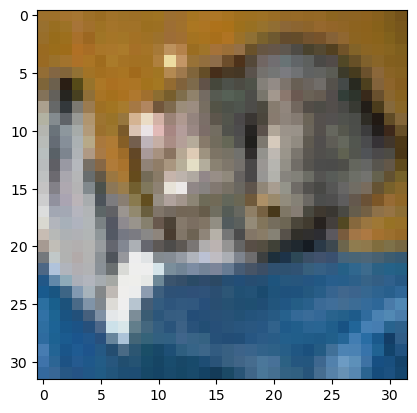

In [39]:
xlab.utils.show_image(img_adv.cpu())

## Further Exploration

Congratulations on finishing this notebook! The Carlini-Wagner attack is influential and well designed, but is also much more difficult than the content you encountered in the previous section.

If you are interested in exploring this attack further there are a few aspects of the paper which we did not cover which you may find informative:

1. For the $L_2$ attack, the authors use multiple starting points for their gradients descent to reduce the likelihood that the optimization becomes stuck in a local minima. Implementation details for this can be found on page 9 of [the paper](https://arxiv.org/pdf/1608.04644).
2. There are also implementation details in the paper for two other kinds of CW attacks: the $L_0$ and $L_\infty$ attacks. Now that you have completed the $L_2$ attack, the $L_\infty$ should not be too difficult because it is moslty the same.
3. Benchmarking FGSM, PGD and CW on different datasets. You should find that each attack has it's own advantages and disadvantages. CW, for example, may be more effective against some defenses while FSGM attacks should have a higher likelihood of transfering to an entirely different model.